# ml lab3

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 0. load mnist data

In [69]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)        

In [70]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [98]:
from random import randrange

def show_images(X, y, shift=0):
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for ax in axs:
        i = randrange(X.shape[0])
        ax.imshow(X[i, :, :, 0])
        ax.set_title(y[i] + shift)
        ax.axis('off')

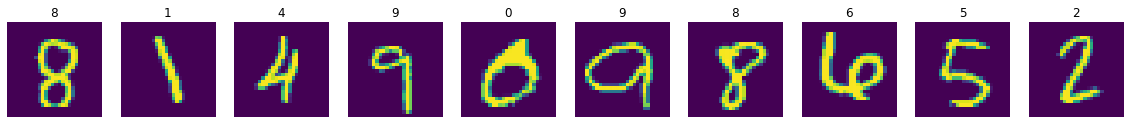

In [72]:
show_images(X_train, y_train)

### 1. build network

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Activation

def build_model(image_shape, output_size):
    model = Sequential()
    model.add(Conv2D(32, 3, padding='same', input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(64, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(output_size))
    model.add(Activation('softmax'))
    
    return model

In [15]:
from keras_tqdm import TQDMNotebookCallback

model = build_model(X_train.shape[1:], 10)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TQDMNotebookCallback()]
)

Using TensorFlow backend.


In [30]:
def plot(_history):    
    plt.figure(figsize=(8, 6))
    plt.plot(_history.history['accuracy'], 'r')
    plt.plot(_history.history['val_accuracy'], 'b')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

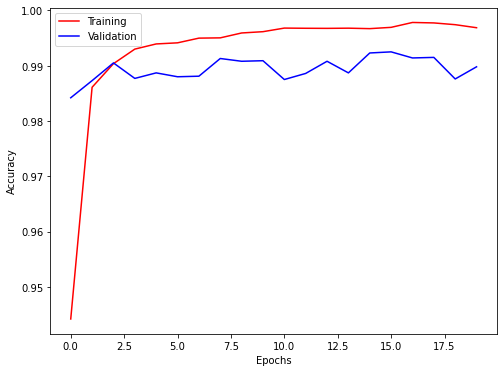

In [31]:
plot(history)

### 2. train on svhn data

In [49]:
import os
import requests
import humanize

DATA_DIR = './data'

def fetch(url):
    filename = os.path.basename(url)
    filepath = f'{DATA_DIR}/{filename}'
    
    if os.path.exists(filepath):
        return
    
    r = requests.get(url)
    size = r.headers.get('content-length', 0)
    print(filepath)
    print(f'size:\t{humanize.naturalsize(size)}')
    
    os.makedirs(DATA_DIR, exist_ok=True)

    with open(filepath, 'wb') as f:
        f.write(r.content)

In [50]:
fetch('http://ufldl.stanford.edu/housenumbers/train_32x32.mat')

./data/train_32x32.mat
size:	182.0 MB


In [51]:
fetch('http://ufldl.stanford.edu/housenumbers/test_32x32.mat')

./data/test_32x32.mat
size:	64.3 MB


In [73]:
import scipy.io

def read_data(filename):
    filepath = f'{DATA_DIR}/{filename}'
    data = scipy.io.loadmat(filepath)
    return np.moveaxis(data['X'], -1, 0), data['y'].flatten() - 1

X_train, y_train = read_data('train_32x32.mat')
X_test, y_test = read_data('test_32x32.mat')

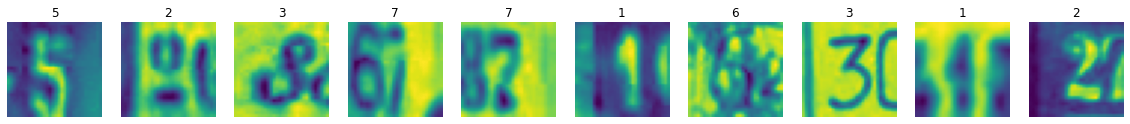

In [101]:
show_images(X_train, y_train, 1)

In [102]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [79]:
model = build_model(X_train.shape[1:], len(np.unique(y_train)))

In [117]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 15, 15, 64)       

In [80]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TQDMNotebookCallback()]
)

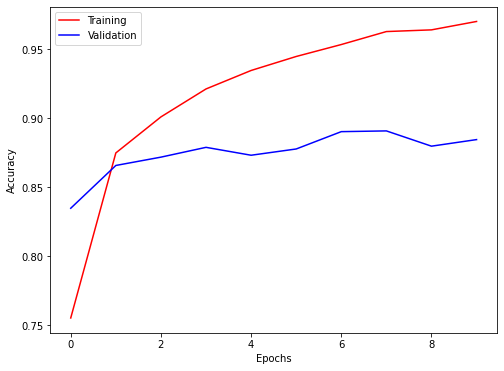

In [81]:
plot(history)

In [89]:
loss, acc = model.evaluate(X_test, y_test, batch_size=128)

26032/26032 [==============================] - 3s 98us/sample - loss: 0.8024 - accuracy: 0.8846


In [92]:
print(f'{acc * 100:.2f}%')

88.46%


In [119]:
predictions = model.predict_classes(X_test)

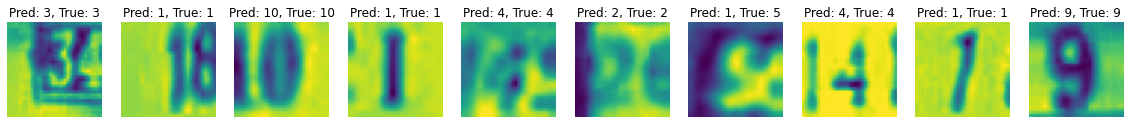

In [124]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for ax in axs:
    i = randrange(X_test.shape[0])
    ax.imshow(X_test[i, :, :, 0])
    ax.set_title(f'Pred: {predictions[i] + 1}, True: {y_test[i] + 1}')
    ax.axis('off')

### 3. save model

In [123]:
model.save(f'{DATA_DIR}/svhn_model.h5', save_format='h5')